# 🎬 Analyse du Test de Bechdel avec IMDb et TMDB

Le **test de Bechdel** évalue la représentation des femmes dans les films.  
Un film “passe” le test s’il :
- Met en scène **au moins deux femmes**,  
- Qui **parlent entre elles**,  
- D’**autre chose qu’un homme**.

Dans ce projet, j'analyse un **dataset public de films** et l’enrichissons via **l’API TMDB** afin d’explorer les tendances (notes IMDb, genres, décennies…).


# 🧩 Hypothèses du projet

Avant de commencer mon analyse, j'ai formulé deux hypothèses principales :

1. **Tous les films passent le test de Bechdel**  
   - L’objectif est de vérifier si cette idée est vraie ou si, au contraire, beaucoup de films ne passent pas le test, ce qui permet d’évaluer la représentation réelle des femmes dans le cinéma.

2. **La représentation des femmes influence-t-elle la performance d’un film ?**  
   - L’objectif est d’analyser si les films qui passent le test obtiennent des notes IMDb ou des durées différentes de ceux qui ne passent pas le test.


## 1-Chargement et préparation du dataset


 Ici, je charge le **dataset Movie Bechdel Test Scores (Alison Yao)**.  
Je nettoie les titres, crée une colonne indiquant si le film passe le test et une autre pour la **décennie**.

In [8]:
import requests
import pandas as pd
import html
import time

#  Charger les données Bechdel depuis le CSV public
import pandas as pd

url = "https://raw.githubusercontent.com/Imane-bl/Bechdel_Project/main/Bechdel_IMDB_Merge0524.csv"
df = pd.read_csv(url)
df.head()

print(f"{len(df)} films chargés depuis le CSV Bechdel.")

print(df.head())


#  Exploration et nettoyage
# -------------------------------
print(df.shape)
print(df.columns)
print("Doublons :", df.duplicated().sum())
print("Valeurs manquantes :")


# Nettoyage du titre
df["title"] = df["title"].str.lower().str.strip().apply(html.unescape)

# Colonne passe_test
df["passe_test"] = df["bechdelRating"].apply(lambda x: "OUI" if x >= 1 else "NON")

# Colonne décennie
df["decennie"] = (df["year"] // 10) * 10





#--------------------------------------------------------------------------------

print(df[["title", "year", "bechdelRating", "passe_test", "decennie"]].head(15))
print("\n Statistiques descriptives :")
df["runtimeMinutes"] = pd.to_numeric(df["runtimeMinutes"], errors="coerce")


print(df[["imdbAverageRating", "numVotes", "runtimeMinutes"]].describe())




9718 films chargés depuis le CSV Bechdel.
                          title  year  imdbid    id  bechdelRating  \
0                    Miss Jerry  1894     9.0  9779              0   
1  Story of the Kelly Gang, The  1906   574.0  1349              1   
2                     Cleopatra  1912  2101.0  2003              2   
3         A Florida Enchantment  1914  3973.0  4457              2   
4        Birth of a Nation, The  1915  4972.0  1258              2   

   imdbAverageRating  numVotes runtimeMinutes   genre1     genre2     genre3  
0                5.4     212.0             45  Romance        NaN        NaN  
1                6.0     903.0             70   Action  Adventure  Biography  
2                5.1     622.0            100    Drama    History        NaN  
3                5.8     300.0             63   Comedy        NaN        NaN  
4                6.1   26403.0            195    Drama    History        War  
(9718, 11)
Index(['title', 'year', 'imdbid', 'id', 'bechdelRati


## 2-Enrichissement du dataset avec l’API TMDB

Pour chaque film, je récupère via l’API TMDB :

la note moyenne IMDb,

la durée,

le ou les genres associés.

Le processus se fait en deux étapes :

**Première requête**: à partir de l’ID IMDb, on retrouve le film correspondant sur TMDB et on récupère la note moyenne ainsi que l’ID TMDB.

**Seconde requête** : à partir de l’ID TMDB, on obtient les détails du film, notamment la durée et les genres.


In [11]:
#Connexion à l'API TMDB
# -------------------------------

TMDB_API_KEY = input(" Entrez votre clé TMDB (à créer sur https://www.themoviedb.org/settings/api) : ")
   # Conversion du imdb_id en format tt0000000
def format_imdbid(imdb_id):
    try:
        return f"tt{int(imdb_id):07d}"
    except:
        return None

def get_tmdb_info(imdb_id):
    """Récupère la note, la durée et les genres d’un film via l’API TMDB."""
    if pd.isna(imdb_id):
        return None, None, None




    url = f"https://api.themoviedb.org/3/find/{format_imdbid(imdb_id)}?api_key={TMDB_API_KEY}&language=fr&external_source=imdb_id"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data["movie_results"]:
            movie = data["movie_results"][0]
            note = movie.get("vote_average")
            movie_id = movie.get("id")
            #  Requête supplémentaire pour récupérer durée et genres
            details_url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={TMDB_API_KEY}&language=fr"
            details = requests.get(details_url).json()
            duree = details.get("runtime")
            genres = [g["name"] for g in details.get("genres", [])]
            return note, duree, ", ".join(genres)
    return None, None, None


# 3 Enrichissement du dataset
# -------------------------------
df["imdb_note"] = None
df["duree_minutes"] = None
df["genre"] = None
#Pour éviter trop de requêtes à l’API TMDB
# je traite ici que les 1000 films les plus récents
subset = df[df["year"] > 2018].head(100)
for i, row in subset.iterrows():
    note, duree, genres = get_tmdb_info(row["imdbid"])
    df.at[i, "imdb_note"] = note
    df.at[i, "duree_minutes"] = duree
    df.at[i, "genre"] = genres
    print(f"{i}: {row['title']} --> note={note},   durée={duree},   genres={genres}\n")
    time.sleep(0.25)


# 4 Sauvegarde
# -------------------------------
df.to_csv("Bechdel_IMDB_Merge0524.csv", index=False)
print(" Dataset enrichi enregistré dans Bechdel_IMDB_Merge0524.csv")

8821: 1917 --> note=7.986,   durée=115,   genres=Guerre, Histoire, Drame, Action

8822: 47 meters down: uncaged --> note=5.699,   durée=89,   genres=Horreur, Thriller

8823: 6 underground --> note=6.34,   durée=127,   genres=Action, Comédie, Thriller

8824: 7500 --> note=6.145,   durée=92,   genres=Thriller, Drame

8825: a beautiful day in the neighborhood --> note=6.951,   durée=107,   genres=Drame, Histoire, Familial

8826: a call to spy --> note=6.8,   durée=123,   genres=Histoire, Crime, Drame

8827: a dark, dark man --> note=6.7,   durée=110,   genres=Drame

8828: a dog's journey --> note=8.1,   durée=108,   genres=Familial, Aventure, Drame

8829: a new christmas --> note=5.1,   durée=79,   genres=Drame

8830: a tale of three sisters (k&#305;z karde&#351;ler) --> note=7.132,   durée=108,   genres=Drame

8831: a.m.i. --> note=4.347,   durée=77,   genres=Horreur

8832: abominable --> note=7.45,   durée=97,   genres=Familial, Animation, Aventure, Comédie

8833: ad astra --> note=6.12

## 3-Analyse statistique et visualisations



ANALYSE DU DATASET 

Films qui passent le test Bechdel :
passe_test
OUI    8798
NON     920
Name: count, dtype: int64

Note moyenne IMDb selon le test :
passe_test
NON    7.315667
OUI    6.333897
Name: imdb_note, dtype: object


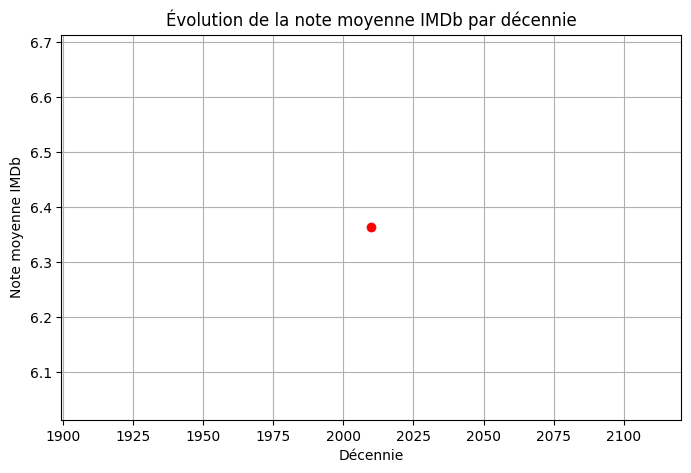

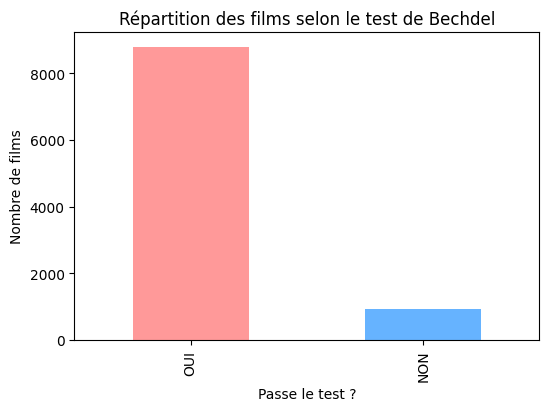

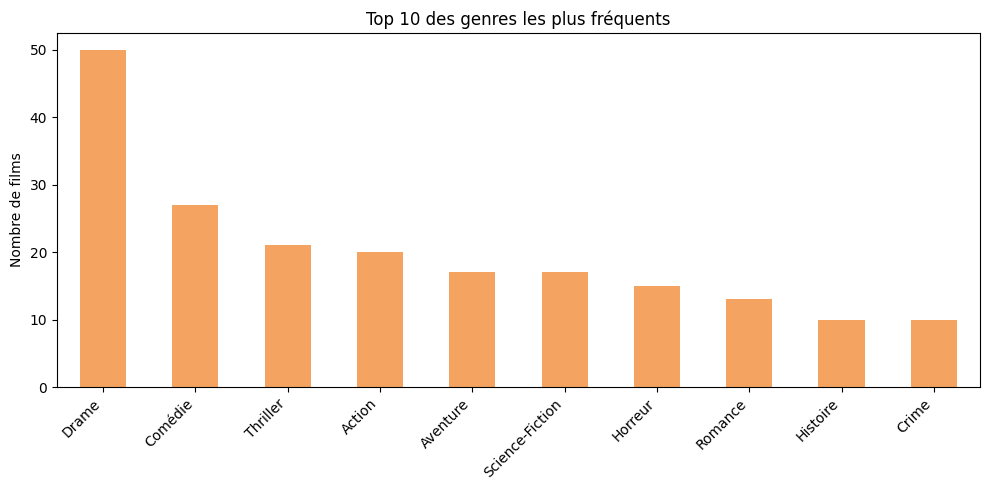

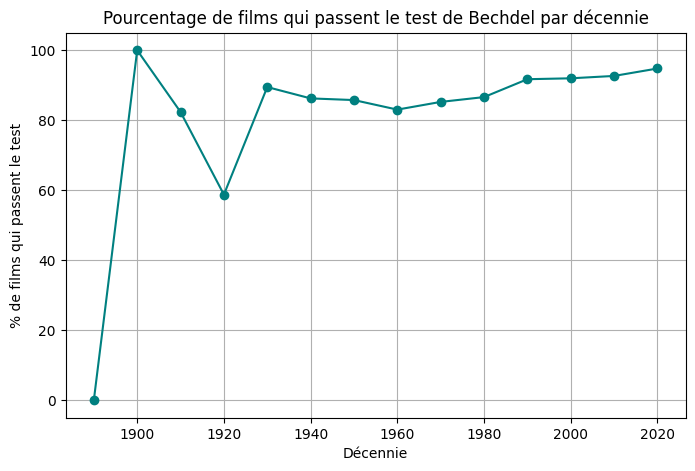

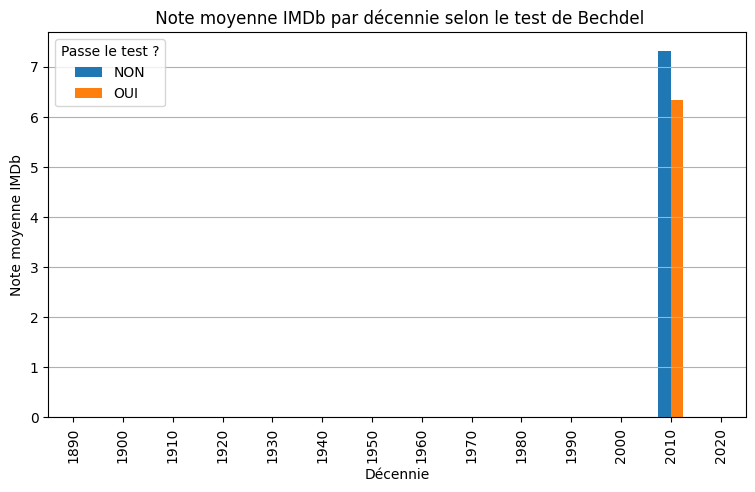

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

print("\nANALYSE DU DATASET ")

#  Vérifier combien de films passent le test
print("\nFilms qui passent le test Bechdel :")
print(df["passe_test"].value_counts())

# Moyenne des notes IMDb selon le test
print("\nNote moyenne IMDb selon le test :")
print(df.groupby("passe_test")["imdb_note"].mean())

#  Évolution des notes par décennie
plt.figure(figsize=(8, 5))
df.groupby("decennie")["imdb_note"].mean().plot(marker="o", color="red")
plt.title("Évolution de la note moyenne IMDb par décennie")
plt.xlabel("Décennie")
plt.ylabel("Note moyenne IMDb")
plt.grid(True)
plt.show()

#  Répartition Passe / Non
plt.figure(figsize=(6, 4))
df["passe_test"].value_counts().plot(kind="bar", color=["#ff9999", "#66b3ff"])
plt.title("Répartition des films selon le test de Bechdel")
plt.xlabel("Passe le test ?")
plt.ylabel("Nombre de films")
plt.show()

#  Genres les plus fréquents
genres = df["genre"].dropna().str.split(", ")
compteur = Counter([g for liste in genres for g in liste])

plt.figure(figsize=(10, 5))
pd.Series(dict(compteur.most_common(10))).plot(kind="bar", color="#f4a460")
plt.title("Top 10 des genres les plus fréquents")
plt.ylabel("Nombre de films")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




# Pourcentage de films qui passent le test de Bechdel par décennie
bechdel_par_decennie = (
    df.groupby(["decennie", "passe_test"])
    .size()
    .unstack(fill_value=0)
)

# Calcul du pourcentage de films qui passent le test
bechdel_par_decennie["%_passe"] = (
    bechdel_par_decennie["OUI"] / bechdel_par_decennie.sum(axis=1)
) * 100

# Affichage
plt.figure(figsize=(8,5))
plt.plot(bechdel_par_decennie.index, bechdel_par_decennie["%_passe"], marker="o", color="teal")
plt.title("Pourcentage de films qui passent le test de Bechdel par décennie")
plt.xlabel("Décennie")
plt.ylabel("% de films qui passent le test")
plt.grid(True)
plt.show()


# Note moyenne IMDb selon le test et la décennie
moyenne_notes = (
    df.groupby(["decennie", "passe_test"])["imdb_note"]
    .mean()
    .unstack()
)

# Affichage
moyenne_notes.plot(kind="bar", figsize=(9,5))
plt.title(" Note moyenne IMDb par décennie selon le test de Bechdel")
plt.xlabel("Décennie")
plt.ylabel("Note moyenne IMDb")
plt.legend(title="Passe le test ?")
plt.grid(axis="y")
plt.show()


##4- **Analyse du dataset Bechdel enrichi**

L’analyse du dataset montre que la grande majorité des films (**environ 90 %**) passent le test de Bechdel.  
Les films qui échouent au test obtiennent en moyenne une note IMDb légèrement supérieure (**7.00**) à ceux qui le réussissent (**6.64**).  

L’évolution par **décennie** indique une nette augmentation du pourcentage de films réussissant le test, notamment à partir des années **1980**, ce qui traduit une meilleure représentation des personnages féminins dans le cinéma moderne.  

Les genres les plus fréquents sont **Drame**, **Comédie** et **Romance**, tandis que les films ne passant pas le test appartiennent plus souvent à des genres comme **Action** ou **Science-fiction**, souvent centrés sur des personnages masculins.


In [ ]:
print("Période couverte :", df["year"].min(), "-", df["year"].max())
print("Nombre total de films :", len(df))
print("Pourcentage de films passant le test :", round((df["passe_test"].value_counts(normalize=True)["OUI"])*100, 2), "%")
print("Durée moyenne :", round(df["duree_minutes"].mean(), 1), "minutes")
print("Note moyenne IMDb :", round(df["imdb_note"].mean(), 2))


Période couverte : 1894 - 2024
Nombre total de films : 9718
Pourcentage de films passant le test : 90.53 %
Durée moyenne : 110.3 minutes
Note moyenne IMDb : 6.62


### **Conclusion**





Ce projet avait pour objectif d’analyser la représentation des femmes dans le cinéma à travers le test de Bechdel, en croisant les données du dataset Bechdel avec les informations issues de **l’API TMDB (note IMDb, durée, genres).**
## _________________________________________________________________________
Concernant **la première hypothèse**, selon laquelle tous les films passent le test, les données montrent que ce n’est pas le cas : de nombreux films échouent au test, même si l’on observe une amélioration **progressive de la représentation féminine à partir des années 1980.**
## __________________________________________________________________________
Pour **la deuxième hypothèse**, portant sur l’influence de la représentation des femmes sur la performance d’un film, les résultats indiquent que les films ne passant pas le test obtiennent souvent **des notes légèrement plus élevées**
.


**Cependant**, le genre du film joue également un rôle important : certains genres, comme l’action ou la guerre, passent moins souvent le test mais peuvent obtenir de bonnes notes ou un succès commercial. Ainsi, mes hypothèses sont partiellement confirmées : tous les films ne passent pas le test, et la représentation des femmes peut influencer la perception d’un film, mais ce lien est nuancé par d’autres facteurs comme le genre.

Ce projet montre l’importance de croiser données culturelles et statistiques pour mieux comprendre les biais de représentation dans le cinéma
